In [2]:
import networkx as nx
import cenpy
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily

In [3]:
ct = "Connecticut, USA"
ct_NewH = ['New Haven County, Connecticut, USA']
ct_Mids = ['Middlesex County, Connecticut, USA']
ct_Tola = ['Tolland County, Connecticut, USA']
ct_Hart = ['Hartford County, Connecticut, USA']
ct_Fair = ['Fairfield County, Connecticut, USA']
          #{'city':'Los Altos Hills', 'state':'California'},
          #'Loyola, California']

desired_building_types = ['industrial','manufacture','factory']

In [4]:
def footprint_squarefeet(place_name, building_types):
    graph = ox.graph_from_place(place_name, network_type='all')
    area = ox.geocode_to_gdf(place_name)
    bldgs = ox.geometries_from_place(place_name, tags={'building': building_types})

    building_geometries_series = gpd.GeoSeries(bldgs.geometry)
    total_footprint_area = building_geometries_series.area.sum()
    projected_crs = 'EPSG:6433'
    building_geometries_projected = bldgs.to_crs(projected_crs)
    total_footprint_area_projected = building_geometries_projected.area.sum()
    
    #print("Total Building Footprint Area:", total_footprint_area)
    #print("Total Building Footprint Area (Projected):", total_footprint_area_projected) #square feet
    return total_footprint_area_projected

In [5]:
ct = footprint_squarefeet(ct, desired_building_types)
NewH = footprint_squarefeet(ct_NewH, desired_building_types)
Mids = footprint_squarefeet(ct_Mids, desired_building_types)
Tola = footprint_squarefeet(ct_Tola, desired_building_types)
Hart = footprint_squarefeet(ct_Hart, desired_building_types)
Fair = footprint_squarefeet(ct_Fair, desired_building_types)

C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_3636\4126494917.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  bldgs = ox.geometries_from_place(place_name, tags={'building': building_types})
C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_3636\4126494917.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  total_footprint_area = building_geometries_series.area.sum()
C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_3636\4126494917.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function

In [6]:
footprint = pd.DataFrame({
        'County': ['New Haven','Hartford','Middlesex','Tolland','Fairfield','Statewide'],
        'Total Footprint Area (square feet)': [NewH,Hart,Mids,Tola,Fair,ct]
    })

footprint['Ratio'] = footprint['Total Footprint Area (square feet)']/ct

import pandas as pd
ct_emissions = pd.read_excel('C:/Users/peiyaozhao/Documents/GitHub/tracking-msa-ghg/data/raw/Public GHG data 1990-2021.xlsx', sheet_name="Emission Totals")

emi = ct_emissions.at[9,'2020 est']
footprint['GHG Emissions/MMTCO2e'] = footprint['Ratio']*emi
rows_to_sum = [1, 2, 3]

# Calculate the sum of the selected rows
sum_result = footprint.iloc[rows_to_sum].sum()
newH_footprint = footprint.iloc[0]
Fair_footprint = footprint.iloc[4]
state_footprint = footprint.iloc[5]


# Choose two rows by label (index)
rows_to_extract = [0, 4,5]

# Extract the selected rows into a new DataFrame
footprint_msa = footprint.loc[rows_to_extract].copy()

# Remove the selected rows from the original DataFrame
#footprint_msa = footprint.drop(rows_to_extract)
position_to_add = 2

# Concatenate the DataFrame before and after the new row
footprint_msa = pd.concat([footprint_msa.iloc[:position_to_add], pd.DataFrame([sum_result]), footprint_msa.iloc[position_to_add:]]).reset_index(drop=True)

footprint_msa.loc[0, 'County'] = 'New Haven-Milford'
footprint_msa.loc[1, 'County'] = 'Bridgeport-Stamford-Norwalk'
footprint_msa.loc[2, 'County'] = 'Hartford-East Hartford-Middletown'


new_row = {
    'County': 'Rest of the state',
    'Total Footprint Area (square feet)': footprint_msa.iloc[3]['Total Footprint Area (square feet)'] - footprint_msa.iloc[:3]['Total Footprint Area (square feet)'].sum(),
    'Ratio': footprint_msa.iloc[3]['Ratio'] - footprint_msa.iloc[:3]['Ratio'].sum(),
    'GHG Emissions/MMTCO2e': footprint_msa.iloc[3]['GHG Emissions/MMTCO2e'] - footprint_msa.iloc[:3]['GHG Emissions/MMTCO2e'].sum()
}

footprint_msa = pd.concat([footprint_msa.iloc[:3], pd.DataFrame([new_row]), footprint_msa.iloc[3:]]).reset_index(drop=True)

msa = footprint_msa.iloc[0:3,0]
values = footprint_msa.iloc[0:3,-1]
Footprint_ratio = footprint_msa.iloc[0:4,2]
categories = footprint_msa.iloc[0:4,1]

footprint_msa 

,County,Total Footprint Area (square feet),Ratio,GHG Emissions/MMTCO2e
0,New Haven-Milford,2.953017e+05,0.142529,0.445960
1,Bridgeport-Stamford-Norwalk,2.530338e+05,0.122128,0.382128
2,Hartford-East Hartford-Middletown,9.784619e+05,0.472261,1.477657
3,Rest of the state,5.450696e+05,0.263081,0.823155
4,Statewide,2.071867e+06,1.000000,3.128899


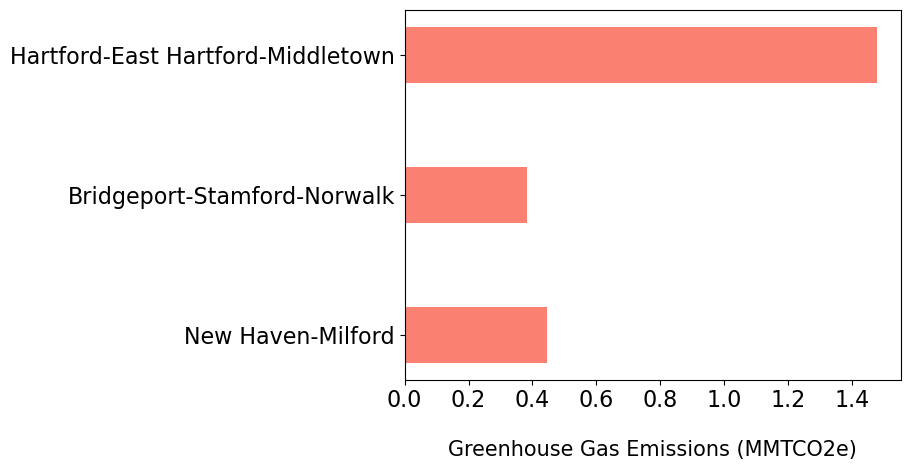

In [8]:
plt.barh(msa, values, 0.4, color="salmon")
plt.xlabel("Greenhouse Gas Emissions (MMTCO2e)",fontsize=15, labelpad=20)

plt.xticks(fontsize=16)  # Adjust the font size as needed
plt.yticks(fontsize=16)

#plt.show() 

plt.savefig('C:/Users/peiyaozhao/Documents/GitHub/tracking-msa-ghg/figures/industrial-emissions-osmnx.png', dpi=100,bbox_inches='tight')